# Predicting Opioid Mortality Rate - In Depth Analysis (Machine Learning, Population Adjusted)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xgboost as xgb
import warnings
import collections
import scipy
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, recall_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from joblib import Parallel, delayed
from itertools import islice

In [2]:
# suppress warnings
warnings.filterwarnings('ignore')

In [3]:
merged_remove = pd.read_csv('merged_remove.csv')

In [4]:
merged_remove['gq_%_of_total_pop'] = merged_remove['GQ Estimates 2016 (count)'] / \
                                     merged_remove['Population Estimate 2016 (count)'] * 100

In [5]:
merged_remove['%_pop_chg'] = merged_remove['Population Change 2016 (count)'] / \
                                     merged_remove['Population Estimate 2016 (count)'] * 100

In [6]:
merged_remove = merged_remove.loc[merged_remove['Population Estimate 2016 (count)'] >=18646, :]

In [7]:
merged_remove.shape

(1884, 38)

In [8]:
merged_remove.drop(columns = ['Population Estimate 2016 (count)', 
                              'GQ Estimates 2016 (count)',
                              'Population Change 2016 (count)'], inplace = True)

In [9]:
y = merged_remove['Crude Opioid Mortality Rate (per 100,000)']
X = merged_remove.drop(columns = 'Crude Opioid Mortality Rate (per 100,000)')

# Road Map

1. PCA
3. Multiple Linear Regression
4. Linear Regression with Regularization
    * Ridge Regression
    * LASSO Regression
    * Elastic Net Regression
* CART
6. Random Forest Regression
7. Stochastic Gradient Boosting Regression
    * scikit-learn
    * xgboost

# Principal Component Analysis

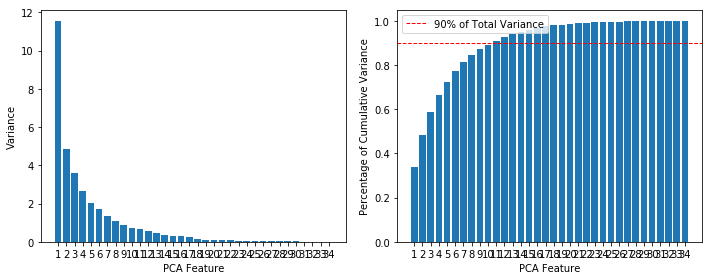

In [10]:
scaler = StandardScaler() # scale data to mean 0 and variance 1

pca = PCA()
pipeline = make_pipeline(scaler, pca)
pipeline.fit(X)

# Plot the explained variances
variance_by_pc = np.array(range(pca.n_components_)) + 1

f, (ax1 ,ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

ax1.bar(variance_by_pc, pca.explained_variance_)
ax1.set_xlabel('PCA Feature')
ax1.set_ylabel('Variance')
ax1.set_xticks(ticks = variance_by_pc)

ax2.bar(variance_by_pc, np.cumsum(pca.explained_variance_ratio_))
ax2.set_xlabel('PCA Feature')
ax2.set_ylabel('Percentage of Cumulative Variance')
ax2.set_xticks(ticks = variance_by_pc)
ax2.axhline(y = 0.9, linestyle = 'dashed', linewidth=1, color='r', label = '90% of Total Variance')
ax2.legend()

f.tight_layout()
f.show()

In [11]:
pca_features = pipeline.transform(X)

In [12]:
pca_features.shape

(1884, 34)

In [13]:
%matplotlib inline

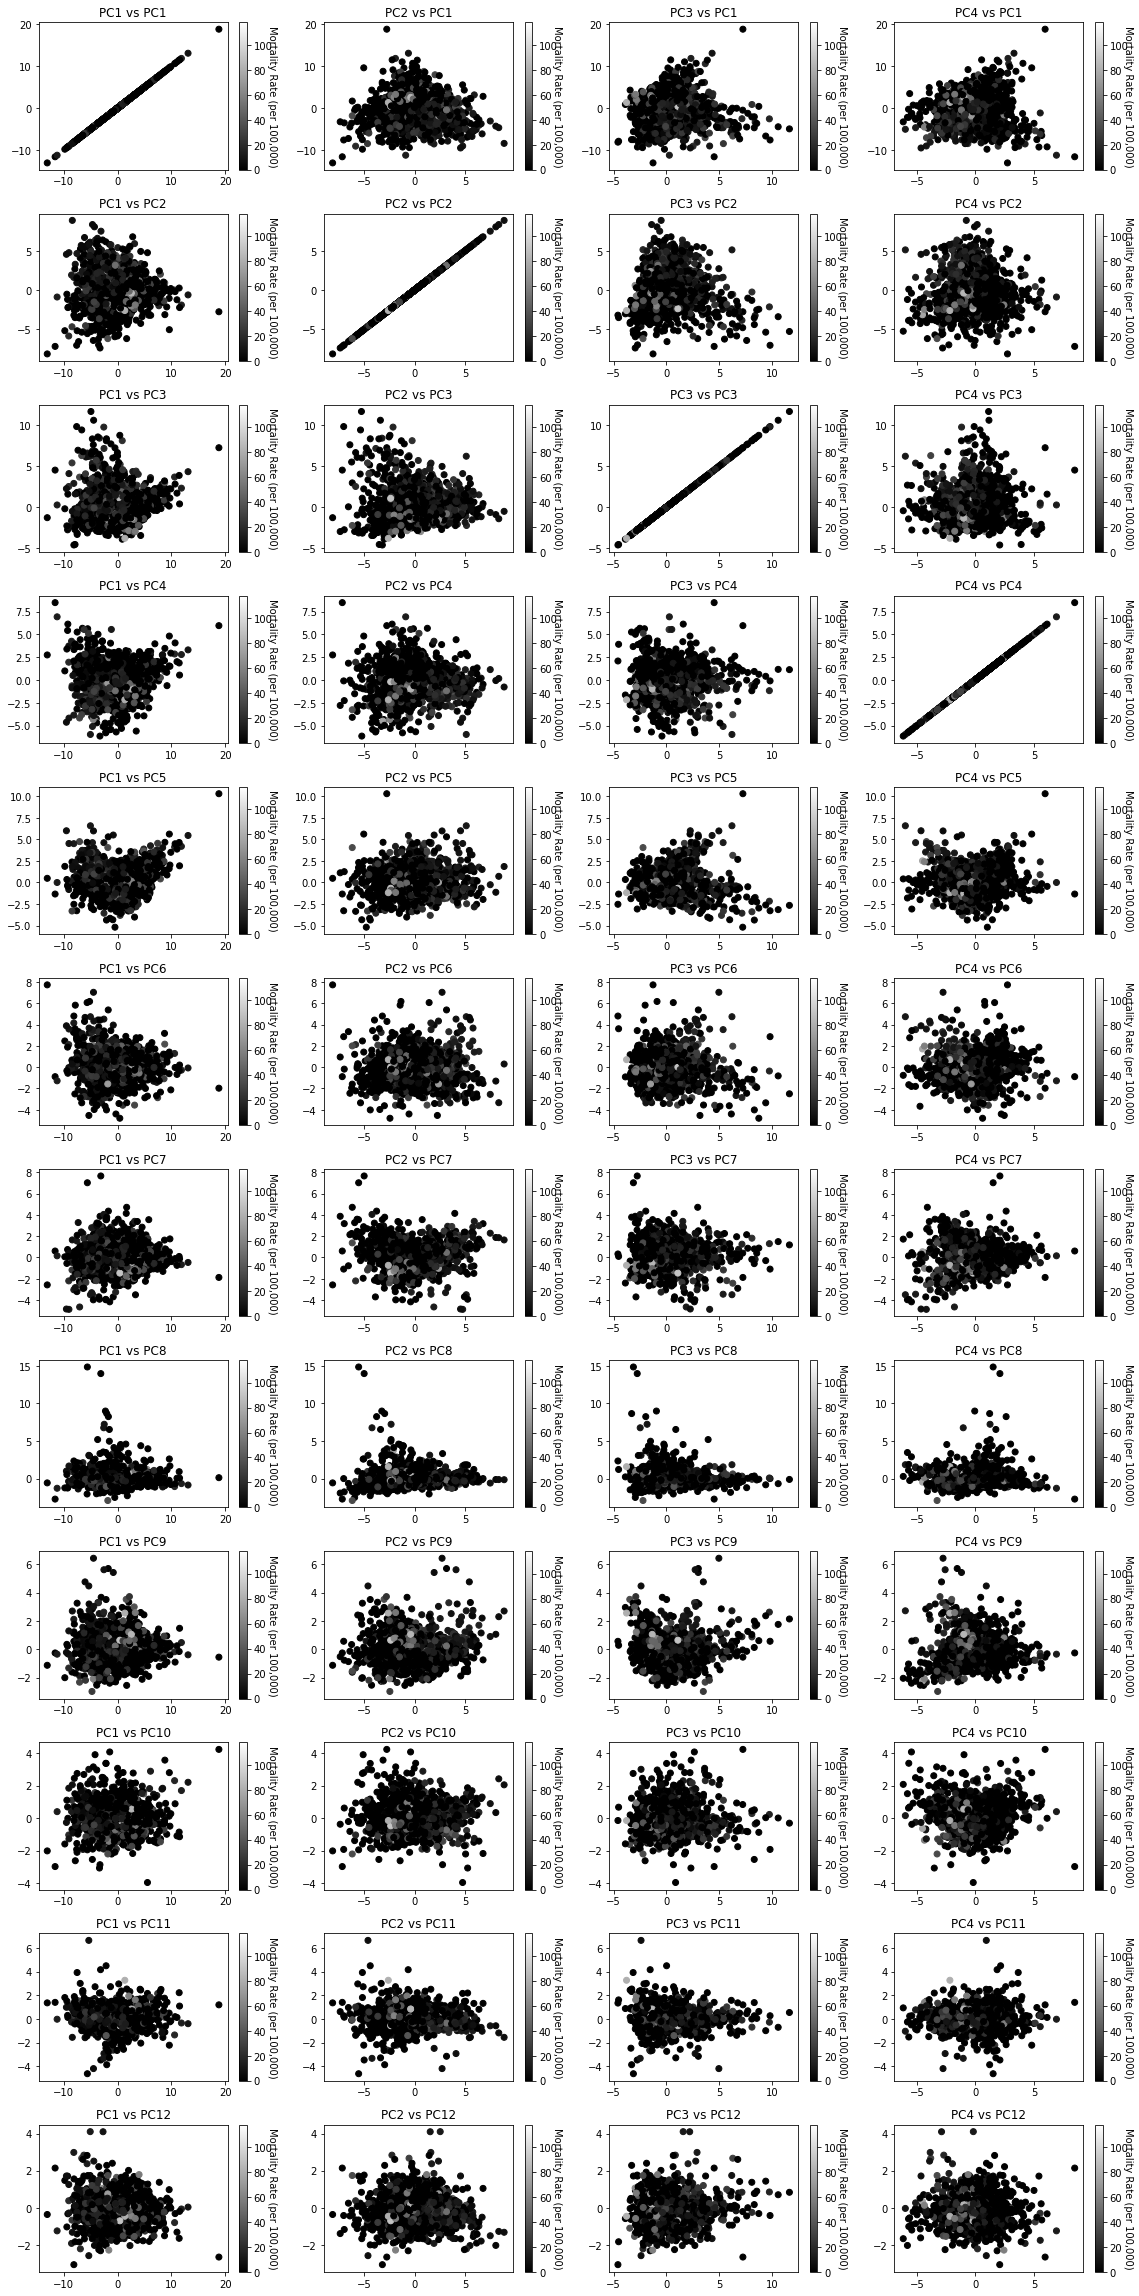

In [14]:
nrows, ncols = 12, 4

f, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (16, 32))

for i, ax in enumerate(axes):
    
    for j in range(ncols):
        
        pos = ax[j].scatter(x = pca_features[:, j], y = pca_features[:, i], c = y, cmap='gray')
        ax[j].set_title('PC{} vs PC{}'.format(j+1,i+1))
        cbar = f.colorbar(mappable = pos, ax = ax[j])
        cbar.set_label('Mortality Rate (per 100,000)', rotation = 270)

f.tight_layout()    
f.show()

In [15]:
# set seed for reproducibility
SEED = 123

# split dataset into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

In [16]:
n_iter = 1000

In [17]:
def best_model_generator(fitted_model):
    """From the fitted model, returns the best model
       Also prints best hyperparameter values and test set rmse for fitted model"""
    # Extract the best hyperparameters from 'grid_elastic_net'
    best_hyperparams = fitted_model.best_params_

    print('Best hyperparameters:\n', best_hyperparams)

    # extract best model
    best_model = fitted_model.best_estimator_

    # predict the test set labels
    y_pred = best_model.predict(X_test)

    # Compute rmse_test
    rmse_test = MSE(y_test, y_pred)**0.5

    # Print rmse_test
    print('Test RMSE of best model: {:.3f}'.format(rmse_test)) 
    
    # return best model
    return best_model

In [18]:
# # configure bootstrap using parallel for loop
# n_iterations = 1000
# # SEEDS = resample(range(1000), n_samples = n_iterations, random_state = SEED, replace = False)
# inputs = range(n_iterations)
# n_size = int(len(merged_remove) * 0.80)

# def bootstrap_rmse(i, model):
#     """Given model, function returns n_iterations of rmse from bootstrap sampling"""
#     train = resample(merged_remove, n_samples=n_size)
#     test_idx = [index for index in merged_remove.index if index not in train.index]
#     test = merged_remove.iloc[merged_remove.index.isin(test_idx), :]
#     # define X_train, y_train, X_test, y_test
#     X_train = train.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)'])
#     y_train = train['Crude Opioid Mortality Rate (per 100,000)']
#     X_test = test.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)'])
#     y_test = test['Crude Opioid Mortality Rate (per 100,000)']

#     model.fit(X_train, y_train)
#     # evaluate model
#     predictions = model.predict(X_test)
#     rmse = MSE(y_test, predictions)**0.5
#     return rmse

In [19]:
def plot_bootstrap_histogram(bootstrap_distribution, plot_label):
    """plots bootstrap histogram from bootstrap sampling and also prints 95% bootstrap CI values"""
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    sns.distplot(bootstrap_distribution, kde=False, rug=True, ax = ax)
    ax.set_title('Bootstrap Distribution of RMSE\n{}'.format(plot_label))
    fig.show()

In [20]:
def feature_importance_plot(model, plot_label):
    """Input is a model and plot label
       Output is a feature importance horizontal bar plot"""
    # create a pd.Series of features importances
    feature_importances = pd.Series(model.feature_importances_, index = X.columns)

    # sort feature_importances
    sorted_importances = feature_importances.sort_values()

    # make a horizontal bar plot
    f, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 12))
    sorted_importances.plot(kind = 'barh', color = 'lightgreen', ax=ax)
    ax.set_title('Feature Importance Based on {}'.format(plot_label))
    f.show()

In [21]:
def fit_predict(X_train, y_train, X_test, model):
    model.fit(X_train, y_train)
    return model.predict(X_test)

In [22]:
def rmse_from_predictions(X_train, y_train, X_test, y_test, model):
    predictions = fit_predict(X_train, y_train, X_test, model)
    return MSE(y_test, predictions) ** 0.5

# Multiple Linear Regression

In [23]:
# Multiple Linear Regression

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('linear', LinearRegression())]

linear_pipeline = Pipeline(steps)

# fit to the training data
linear_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred_lr = linear_pipeline.predict(X_test)

# Compute rmse_test
rmse_test_lr = MSE(y_test, y_pred_lr)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_lr)) 

Test RMSE of best model: 10.278


# Ridge Regression

## No hyperparameter tuning

In [24]:
# Ridge (no hyperparameter tuning)# Ridge  

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('ridge', Ridge(random_state = SEED))]

ridge_pipeline = Pipeline(steps)

# fit to the training data
ridge_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred_ridge = ridge_pipeline.predict(X_test)

# Compute rmse_test
rmse_test_ridge = MSE(y_test, y_pred_ridge)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_ridge))

Test RMSE of best model: 10.239


# Ridge Regression

## Hyperparameter Tuning

In [25]:
# Ridge (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('ridge', Ridge(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
ridge_pipeline = Pipeline(steps)

ridge_param_grid = dict(ridge__alpha= np.logspace(-10, 0, 500),
                        ridge__fit_intercept= [True, False])

ridge_randomized_neg_mse = RandomizedSearchCV(estimator = ridge_pipeline, 
                                 param_distributions = ridge_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_ridge' to the training data
ridge_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1015 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 1365 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 1815 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 2365 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 3015 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3765 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4615 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  2.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('st_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=123, solver='auto', tol=0.001))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'ridge__alpha': array([1.00000e-10, 1.04723e-10, ..., 9.54904e-01, 1.00000e+00]), 'ridge__fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=1)

In [26]:
best_model_ridge = best_model_generator(fitted_model = ridge_randomized_neg_mse)

Best hyperparameters:
 {'ridge__fit_intercept': True, 'ridge__alpha': 0.05217168575554355}
Test RMSE of best model: 10.270


# LASSO Regression
## No Hyperparameter Tuning

In [27]:
# LASSO (no hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('lasso', Lasso(random_state = SEED))]

lasso_pipeline = Pipeline(steps)

# fit to the training data
lasso_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred_lasso = lasso_pipeline.predict(X_test)

# Compute rmse_test
rmse_test_lasso = MSE(y_test, y_pred_lasso)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_lasso))

Test RMSE of best model: 10.867


# LASSO Regression

## Hyperparameter Tuning

In [28]:
# LASSO (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('lasso', Lasso(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
lasso_pipeline = Pipeline(steps)

lasso_param_grid = dict(lasso__alpha= np.logspace(-10, 0, 500),
                        lasso__fit_intercept= [True, False])

lasso_randomized_neg_mse = RandomizedSearchCV(estimator = lasso_pipeline, 
                                 param_distributions = lasso_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_lasso' to the training data
lasso_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 510 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 860 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 1310 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1860 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 2510 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 3260 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 4110 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.3min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('st_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=123,
   selection='cyclic', tol=0.0001, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'lasso__alpha': array([1.00000e-10, 1.04723e-10, ..., 9.54904e-01, 1.00000e+00]), 'lasso__fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=1)

In [29]:
best_model_lasso = best_model_generator(fitted_model = lasso_randomized_neg_mse)

Best hyperparameters:
 {'lasso__fit_intercept': True, 'lasso__alpha': 0.0029850382451187293}
Test RMSE of best model: 10.254


# Elastic Net Regression
## No Hyperparameter Tuning

In [30]:
# Elastic Net (no hyperparameter tuning)# Elasti 

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('enet', ElasticNet(random_state = SEED))]

enet_pipeline = Pipeline(steps)

# fit to the training data
enet_pipeline.fit(X_train, y_train)

# predict the test set labels
y_pred_enet = enet_pipeline.predict(X_test)

# Compute rmse_test
rmse_test_enet = MSE(y_test, y_pred_enet)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_enet))

Test RMSE of best model: 10.787


# Elastic Net

## Hyperparameter Tuning

In [31]:
# Elastic Net (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('st_scaler', StandardScaler()),
         ('enet', ElasticNet(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
enet_pipeline = Pipeline(steps)

enet_param_grid = dict(enet__alpha= np.logspace(-10, 0, 500),
                              enet__l1_ratio = np.arange(0, 1, 0.01),
                              enet__fit_intercept= [True, False])

enet_randomized_neg_mse = RandomizedSearchCV(estimator = enet_pipeline, 
                                 param_distributions = enet_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_elastic_net' to the training data
enet_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 992 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1342 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 2342 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 2992 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 3742 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('st_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('enet', ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=123, selection='cyclic', tol=0.0001, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'enet__alpha': array([1.00000e-10, 1.04723e-10, ..., 9.54904e-01, 1.00000e+00]), 'enet__l1_ratio': array([0.  , 0.01, ..., 0.98, 0.99]), 'enet__fit_intercept': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=1)

In [32]:
best_model_enet = best_model_generator(fitted_model = enet_randomized_neg_mse)

Best hyperparameters:
 {'enet__l1_ratio': 0.99, 'enet__fit_intercept': True, 'enet__alpha': 1.153783299629662e-09}
Test RMSE of best model: 10.264


# Classification and Regressor Tree (CART)
## No Hyperparameter Tuning

In [33]:
# CART (no hyperparameter tuning)

# Instantiate dt
dt = DecisionTreeRegressor(random_state=SEED)

# Fit dt to the training set
dt.fit(X_train, y_train)

# Predict test set labels
y_pred_dt = dt.predict(X_test)

# Compute MSE
rmse_test_dt = MSE(y_test, y_pred_dt) ** 0.5

# Print RMSE
print('Test set RMSE of dt: {:.3f}'.format(rmse_test_dt))

Test set RMSE of dt: 15.667


# Classification and Regressor Tree (CART)

## Hyperparameter Tuning

In [34]:
# CART (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('dt', DecisionTreeRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
dt_pipeline = Pipeline(steps)

dt_param_grid = dict(dt__max_depth= np.arange(1, 50, 10),
                     dt__min_samples_split= np.arange(2, 50, 2),
                     dt__min_samples_leaf= np.arange(1, 100, 2))

dt_randomized_neg_mse = RandomizedSearchCV(estimator = dt_pipeline, 
                                 param_distributions = dt_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_dt' to the training data
dt_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 316 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2816 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    3.4s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('dt', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=123, splitter='best'))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'dt__max_depth': array([ 1, 11, 21, 31, 41]), 'dt__min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48]), 'dt__min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99])},
          pre_dispatch='2*n_jobs', random_state=None, 

In [35]:
best_model_dt = best_model_generator(fitted_model = dt_randomized_neg_mse)

Best hyperparameters:
 {'dt__min_samples_split': 28, 'dt__min_samples_leaf': 81, 'dt__max_depth': 11}
Test RMSE of best model: 10.546


# Random Forest Regressor
## No Hyperparameter Tuning

In [36]:
#  random forest (no hyperparameter tuning)

# Instantiate rf
rf = RandomForestRegressor(random_state=SEED)

# Fit rf to the training set
rf.fit(X_train, y_train)

# Predict test set labels
y_pred_rf = rf.predict(X_test)

# Compute RMSE
rmse_test_rf = MSE(y_test, y_pred_rf)**0.5

# Print RMSE
print('Test set RMSE of rf: {:.3f}'.format(rmse_test_rf))

Test set RMSE of rf: 11.361


# Random Forest Regressor

## Hyperparameter Tuning

In [37]:
# RandomForest (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('rf', RandomForestRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
rf_pipeline = Pipeline(steps)

rf_param_grid = dict(rf__n_estimators = np.arange(2, 500, 10),
                     rf__max_depth= np.arange(1, 50, 10),
                     rf__max_features= np.arange(0.05, 1, 0.05),
                     rf__min_samples_split= np.arange(2, 50, 2),
                     rf__min_samples_leaf= np.arange(1, 100, 2),
                     rf__bootstrap= [True, False])

rf_randomized_neg_mse = RandomizedSearchCV(estimator = rf_pipeline, 
                                 param_distributions = rf_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 n_jobs = -1,
                                 verbose = 1)

# fit 'grid_rf' to the training data
rf_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 119 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 786 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 1236 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 1786 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2436 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3186 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 4036 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  3.2min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('rf', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=123, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'rf__n_estimators': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252,
       262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382,
       392, 402, 412, 422, 432, 442, 452, 4...   69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]), 'rf__bootstrap': [True, False]},
          pre_dispatch='2*n_job

In [38]:
best_model_rf = best_model_generator(fitted_model = rf_randomized_neg_mse)

Best hyperparameters:
 {'rf__n_estimators': 62, 'rf__min_samples_split': 8, 'rf__min_samples_leaf': 5, 'rf__max_features': 0.25, 'rf__max_depth': 31, 'rf__bootstrap': False}
Test RMSE of best model: 10.215


# Feature Importance Based on Random Forest Best Model

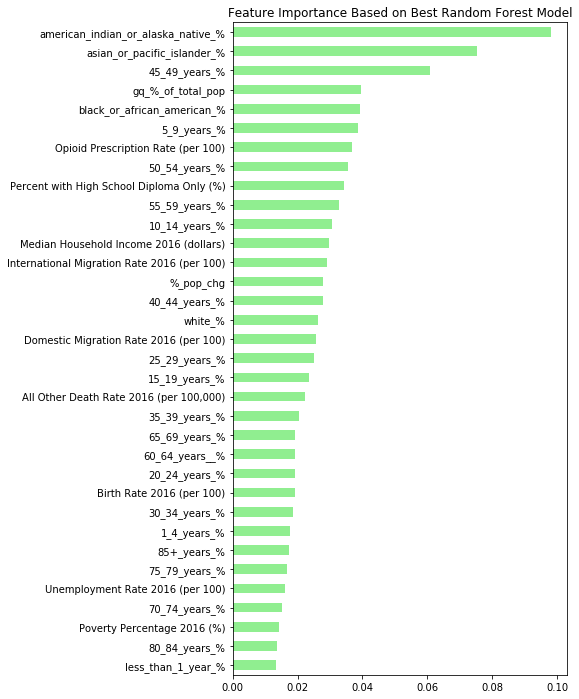

In [39]:
feature_importance_plot(best_model_rf.steps[0][1], 'Best Random Forest Model')

# Gradient Boosting Regressor

## No Hyperparameter Tuning

In [40]:
#  gradient boosting using scikit-learn (no hyperparameter tuning)

# Instantiate gb
gb = GradientBoostingRegressor(random_state=SEED)

# Fit gb to the training set
gb.fit(X_train, y_train)

# Predict test set labels
y_pred_gb = gb.predict(X_test)

# Compute RMSE
rmse_test_gb = MSE(y_test, y_pred_gb)**0.5

# Print RMSE
print('Test set RMSE of gb: {:.3f}'.format(rmse_test_gb))

Test set RMSE of gb: 10.356


# Gradient Boosting Regressor

## Hyperparameter Tuning

In [41]:
# gradient boosting regressor using scikit-learn (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('gb', GradientBoostingRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
gb_pipeline = Pipeline(steps)

gb_param_grid = dict(gb__n_estimators = np.arange(2, 500, 10),
                      gb__max_depth= np.arange(1, 50, 10),
                      gb__min_samples_split= np.arange(2, 50, 2),
                      gb__min_samples_leaf= np.arange(1, 100, 2),
                      gb__learning_rate = np.arange(0.05, 1, 0.05))

gb_randomized_neg_mse = RandomizedSearchCV(estimator = gb_pipeline, 
                                            param_distributions = gb_param_grid, 
                                            scoring = 'neg_mean_squared_error', 
                                            cv = 5,
                                            n_iter = n_iter,
                                            n_jobs = -1,
                                            verbose = 1)

# fit 'grid_gb' to the training data
gb_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  4.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('gb', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, m...s=100, presort='auto', random_state=123,
             subsample=1.0, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'gb__n_estimators': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252,
       262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382,
       392, 402, 412, 422, 432, 442, 452, 4..., 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
          pre_dispatch='2*n_jobs', random_state=None, refit=Tru

In [42]:
best_model_gb = best_model_generator(fitted_model = gb_randomized_neg_mse)

Best hyperparameters:
 {'gb__n_estimators': 152, 'gb__min_samples_split': 34, 'gb__min_samples_leaf': 83, 'gb__max_depth': 21, 'gb__learning_rate': 0.05}
Test RMSE of best model: 10.210


# Stochastic Gradient Boosting Regressor (scikit-learn)

## No Hyperparameter Tuning

In [43]:
# stochastic gradient boosting regressor using scikit-learn (no parameter tuning)

# Instantiate sgbr
sgbr = GradientBoostingRegressor(subsample=0.9,
            max_features=0.75,
            random_state=SEED)

# Fit sgbr to the training set
sgbr.fit(X_train, y_train)

# Predict test set labels
y_pred_sgbr = sgbr.predict(X_test)

# Compute test set RMSE
rmse_test_sgbr = MSE(y_test, y_pred_sgbr)**0.5


# Print rmse_test
print('Test set RMSE of sgbr: {:.3f}'.format(rmse_test_sgbr))

Test set RMSE of sgbr: 10.633


# Stochastic Gradient Boosting Regressor (scikit-learn)

## Hyperparameter Tuning

In [44]:
# stochastic gradient boosting regressor using scikit-learn (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('sgb', GradientBoostingRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
sgb_pipeline = Pipeline(steps)

sgb_param_grid = dict(sgb__n_estimators = np.arange(2, 500, 10),
                      sgb__max_depth= np.arange(1, 50, 10),
                      sgb__max_features= np.arange(0.05, 1, 0.05),
                      sgb__min_samples_split= np.arange(2, 50, 2),
                      sgb__min_samples_leaf= np.arange(1, 100, 2),
                      sgb__subsample= np.arange(0.05, 1, 0.05),
                      sgb__learning_rate = np.arange(0.05, 1, 0.05))

sgb_randomized_neg_mse = RandomizedSearchCV(estimator = sgb_pipeline, 
                                            param_distributions = sgb_param_grid, 
                                            scoring = 'neg_mean_squared_error', 
                                            cv = 5,
                                            n_iter = n_iter,
                                            n_jobs = -1,
                                            verbose = 1)

# fit 'grid_sgb' to the training data
sgb_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 473 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 830 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 1282 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 1832 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 2482 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 3232 tasks      | elapsed:   48.4s
[Parallel(n_jobs=-1)]: Done 4082 tasks      | elapsed:   60.0s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('sgb', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, ...s=100, presort='auto', random_state=123,
             subsample=1.0, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'sgb__n_estimators': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252,
       262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382,
       392, 402, 412, 422, 432, 442, 452, ..., 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
          pre_dispatch='2*n_jobs', random_state=None, refit=Tru

In [45]:
best_model_sgb = best_model_generator(fitted_model = sgb_randomized_neg_mse)

Best hyperparameters:
 {'sgb__subsample': 0.6500000000000001, 'sgb__n_estimators': 92, 'sgb__min_samples_split': 6, 'sgb__min_samples_leaf': 55, 'sgb__max_features': 0.35000000000000003, 'sgb__max_depth': 21, 'sgb__learning_rate': 0.05}
Test RMSE of best model: 10.185


# Stochastic Gradient Boosting Regressor (xgboost)

## No Hyperparameter Tuning

In [46]:
# stochastic gradient boosting regressor using xgboost (no parameter tuning)

# Instantiate xgbr
xgbr = xgb.XGBRegressor(subsample=0.9,
            colsample_bytree=0.75,
            random_state=SEED)

# Fit xgbr to the training set
xgbr.fit(X_train, y_train)

# Predict test set labels
y_pred_xgbr = xgbr.predict(X_test)

# Compute test set RMSE
rmse_test_xgbr = MSE(y_test, y_pred_xgbr)**0.5

# Print rmse_test
print('Test set RMSE of xgbr: {:.3f}'.format(rmse_test_xgbr))

Test set RMSE of xgbr: 10.457


# Feature Importance Based on XGBoost

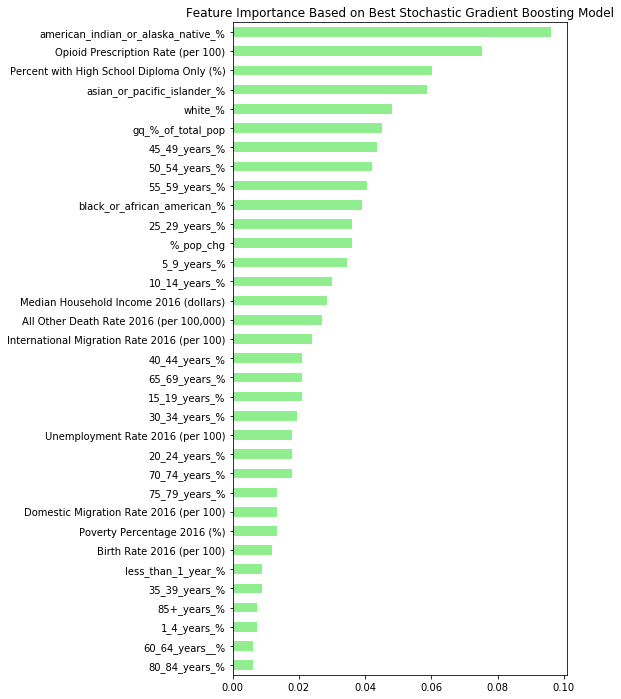

In [47]:
feature_importance_plot(xgbr, 'Best Stochastic Gradient Boosting Model')

# Stochastic Gradient Boosting Regressor (xgboost)

## Hyperparameter Tuning

In [48]:
# Stochastic Gradient Boosting Regressor using xgbroost package (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('xgbr', xgb.XGBRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
xgbr_pipeline = Pipeline(steps)

xgbr_param_grid = dict(xgbr__n_estimators = np.arange(2, 500, 10),
                      xgbr__max_depth= np.arange(1, 50, 1),
                      xgbr__subsample= np.arange(0.05, 1, 0.05),
                      xgbr__colsample_bytree = np.arange(0.05, 1, 0.05),
                      xgbr__learning_rate = np.arange(0.05, 1, 0.05))

xgbr_randomized_neg_mse = RandomizedSearchCV(estimator = xgbr_pipeline, 
                                 param_distributions = xgbr_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 verbose = 1,
                                 n_jobs = -1)

# fit 'grid_xgbr' to the training data
xgbr_randomized_neg_mse.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.7min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('xgbr', XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=123,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'xgbr__n_estimators': array([  2,  12,  22,  32,  42,  52,  62,  72,  82,  92, 102, 112, 122,
       132, 142, 152, 162, 172, 182, 192, 202, 212, 222, 232, 242, 252,
       262, 272, 282, 292, 302, 312, 322, 332, 342, 352, 362, 372, 382,
       392, 402, 412, 422, 432, 442, 452,..., 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])},
          pre_dispatch='2*n

In [49]:
best_model_xgbr = best_model_generator(fitted_model = xgbr_randomized_neg_mse)

Best hyperparameters:
 {'xgbr__subsample': 0.9500000000000001, 'xgbr__n_estimators': 422, 'xgbr__max_depth': 46, 'xgbr__learning_rate': 0.05, 'xgbr__colsample_bytree': 0.7000000000000001}
Test RMSE of best model: 10.024


# Hurdle Approach

In [50]:
merged_remove_hurdle = pd.read_csv('merged_remove.csv')

merged_remove_hurdle['classification'] = np.where(merged_remove_hurdle['Crude Opioid Mortality Rate (per 100,000)'] == 0, 0, 1)

merged_remove_hurdle['gq_%_of_total_pop'] = merged_remove_hurdle['GQ Estimates 2016 (count)'] / \
                                     merged_remove_hurdle['Population Estimate 2016 (count)'] * 100

merged_remove_hurdle['%_pop_chg'] = merged_remove_hurdle['Population Change 2016 (count)'] / \
                                     merged_remove_hurdle['Population Estimate 2016 (count)'] * 100

merged_remove_hurdle = merged_remove_hurdle.loc[merged_remove_hurdle['Population Estimate 2016 (count)'] >=18646, :]

merged_remove_hurdle.drop(columns = ['Population Estimate 2016 (count)', 
                              'GQ Estimates 2016 (count)',
                              'Population Change 2016 (count)'], inplace = True)

In [51]:
y_hurdle = merged_remove_hurdle['classification']
X_hurdle = merged_remove_hurdle.drop(columns = ['classification', 'Crude Opioid Mortality Rate (per 100,000)'])

# set seed for reproducibility
SEED = 123

# split dataset into 80% train and 20% test
X_train_hurdle_clf, X_test_hurdle_clf, y_train_hurdle_clf, y_test_hurdle_clf = train_test_split(X_hurdle, y_hurdle, 
                                                            test_size = 0.2, stratify = y_hurdle, random_state = SEED)

X_train_hurdle_clf.sort_index(inplace = True)

X_test_hurdle_clf.sort_index(inplace = True)

y_train_hurdle_clf.sort_index(inplace = True)

y_test_hurdle_clf.sort_index(inplace = True)

In [52]:
# Stochastic Gradient Boosting Classifier using xgboost package (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('xgbc', xgb.XGBClassifier(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
xgbc_pipeline = Pipeline(steps)

xgbc_param_grid = dict(xgbc__n_estimators = np.arange(2, 500, 10),
                      xgbc__max_depth= np.arange(1, 50, 1),
                      xgbc__subsample= np.arange(0.05, 1, 0.05),
                      xgbc__colsample_bytree = np.arange(0.05, 1, 0.05),
                      xgbc__learning_rate = np.arange(0.05, 1, 0.05))

xgbc_randomized_recall = RandomizedSearchCV(estimator = xgbc_pipeline, 
                                 param_distributions = xgbc_param_grid, 
                                 scoring = 'recall', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 verbose = 1,
                                 n_jobs = -1,
                                 random_state = SEED)

# fit 'xgbc_randomized_recall' to the training data
xgbc_randomized_recall.fit(X_train_hurdle_clf, y_train_hurdle_clf)

# Extract the best hyperparameters from 'grid_xgbc'
best_hyperparams_clf = xgbc_randomized_recall.best_params_

print('Best hyperparameters:\n', best_hyperparams_clf)

# extract best model from 'grid_xgbc'
best_model_xgbc_hurdle = xgbc_randomized_recall.best_estimator_

recall_score(y_test_hurdle_clf, best_model_xgbc_hurdle.predict(X_test_hurdle_clf))

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 513 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 871 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 1321 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 1871 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 2521 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 3271 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 4121 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   47.9s finished


Best hyperparameters:
 {'xgbc__subsample': 0.9000000000000001, 'xgbc__n_estimators': 162, 'xgbc__max_depth': 5, 'xgbc__learning_rate': 0.2, 'xgbc__colsample_bytree': 0.55}


0.6214285714285714

In [53]:
predictions_best_model_train = best_model_xgbc_hurdle.predict(X_train_hurdle_clf)

X_train_hurdle_reg = X_train_hurdle_clf[predictions_best_model_train == 1].sort_index()

y_train_hurdle_reg = merged_remove_hurdle.iloc[merged_remove_hurdle.index.isin(X_train_hurdle_reg.index),\
                                               merged_remove_hurdle.columns.get_loc('Crude Opioid Mortality Rate (per 100,000)')]\
                                               .sort_index()

In [54]:
# Stochastic Gradient Boosting Regressor using xgboost package (hyperparameter tuning)

# set up the pipeline steps: steps
steps = [('xgbr', xgb.XGBRegressor(random_state = SEED))]

# Using pipeline and RandomizedSearchCV to find best parameters and calculate accuracy
xgbr_pipeline = Pipeline(steps)

xgbr_param_grid = dict(xgbr__n_estimators = np.arange(2, 500, 10),
                      xgbr__max_depth= np.arange(1, 50, 1),
                      xgbr__subsample= np.arange(0.05, 1, 0.05),
                      xgbr__colsample_bytree = np.arange(0.05, 1, 0.05),
                      xgbr__learning_rate = np.arange(0.05, 1, 0.05))

xgbr_randomized_neg_mse = RandomizedSearchCV(estimator = xgbr_pipeline, 
                                 param_distributions = xgbr_param_grid, 
                                 scoring = 'neg_mean_squared_error', 
                                 cv = 5,
                                 n_iter = n_iter,
                                 verbose = 1,
                                 n_jobs = -1,
                                 random_state = SEED)

# fit 'grid_xgbr' to the training data
xgbr_randomized_neg_mse.fit(X_train_hurdle_reg, y_train_hurdle_reg)

# Extract the best hyperparameters from 'grid_xgbr'
best_hyperparams_reg = xgbr_randomized_neg_mse.best_params_

print('Best hyperparameters:\n', best_hyperparams_reg)

# extract best model from 'grid_xgbr'
best_model_xgbr_hurdle = xgbr_randomized_neg_mse.best_estimator_

predictions_best_model_test = best_model_xgbc_hurdle.predict(X_test_hurdle_clf)

X_test_hurdle_reg = X_test_hurdle_clf[predictions_best_model_test == 1].sort_index()

y_test_hurdle_reg = merged_remove_hurdle.iloc[merged_remove_hurdle.index.isin(X_test_hurdle_reg.index),\
                                              merged_remove_hurdle.columns.get_loc('Crude Opioid Mortality Rate (per 100,000)')]\
                                              .sort_index()

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 612 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 1312 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 1989 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 2539 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 3189 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 3939 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 4789 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:   30.1s finished


Best hyperparameters:
 {'xgbr__subsample': 0.8, 'xgbr__n_estimators': 92, 'xgbr__max_depth': 2, 'xgbr__learning_rate': 0.1, 'xgbr__colsample_bytree': 0.1}


In [55]:
# predict the test set labels
y_pred_hurdle_reg = best_model_xgbr_hurdle.predict(X_test_hurdle_reg)

# Compute rmse_test
rmse_test_hurdle = MSE(y_test_hurdle_reg, y_pred_hurdle_reg)**0.5

# Print rmse_test
print('Test RMSE of best model: {:.3f}'.format(rmse_test_hurdle)) 

Test RMSE of best model: 14.064


In [56]:
# overall test set rmse

In [57]:
test = merged_remove_hurdle.iloc[merged_remove_hurdle.index.isin(X_test_hurdle_clf.index), :].sort_index()

test['class_prediction'] = best_model_xgbc_hurdle.predict(X_test_hurdle_clf)

test['clf_reg_prediction'] = test['class_prediction']

test_no_mortality_rate = test.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)', 
                                              'classification', 
                                              'class_prediction', 
                                              'clf_reg_prediction'])

test.loc[test.class_prediction == 1, 'clf_reg_prediction'] = \
                            best_model_xgbr_hurdle.predict(test_no_mortality_rate[test.class_prediction == 1])

score = MSE(test.clf_reg_prediction, test['Crude Opioid Mortality Rate (per 100,000)'])**0.5
print(score)

13.627718620917689


In [58]:
def hurdle_bootstrap_rmse(train_index, test_index):
        # hurdle approach
    train = merged_remove_hurdle.iloc[merged_remove_hurdle.index.isin(train_index), :].sort_index()
    test = merged_remove_hurdle.iloc[merged_remove_hurdle.index.isin(test_index), :].sort_index()

    # define X_train_hurdle_clf, y_train_hurdle_clf, X_test_hurdle_clf, y_test_hurdle_clf
    X_train_hurdle_clf = train.drop(columns = ['classification','Crude Opioid Mortality Rate (per 100,000)'])
    y_train_hurdle_clf = train.classification

    X_test_hurdle_clf = test.drop(columns = ['classification','Crude Opioid Mortality Rate (per 100,000)'])
    y_test_hurdle_clf = test.classification

    best_model_xgbc_hurdle.fit(X_train_hurdle_clf, y_train_hurdle_clf)    


    predictions_best_model_train = best_model_xgbc_hurdle.predict(X_train_hurdle_clf)

    X_train_hurdle_reg = X_train_hurdle_clf[predictions_best_model_train == 1].sort_index()

    y_train_hurdle_reg = train.iloc[train.index.isin(X_train_hurdle_reg.index), 
                                    train.columns.get_loc('Crude Opioid Mortality Rate (per 100,000)')].sort_index()


    predictions_best_model_test = best_model_xgbc_hurdle.predict(X_test_hurdle_clf)

    X_test_hurdle_reg = X_test_hurdle_clf[predictions_best_model_test == 1].sort_index()

    y_test_hurdle_reg = test.iloc[test.index.isin(X_test_hurdle_reg.index), 
                                  test.columns.get_loc('Crude Opioid Mortality Rate (per 100,000)')].sort_index()


    best_model_xgbr_hurdle.fit(X_train_hurdle_reg, y_train_hurdle_reg)


    # evaluate model
    test['class_prediction'] = best_model_xgbc_hurdle.predict(X_test_hurdle_clf)

    test['clf_reg_prediction'] = test['class_prediction']

    test_no_mortality_rate = test.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)', 
                                                  'classification', 
                                                  'class_prediction', 
                                                  'clf_reg_prediction'])

    test.loc[test.class_prediction == 1, 'clf_reg_prediction'] = \
                                best_model_xgbr_hurdle.predict(test_no_mortality_rate[test.class_prediction == 1])

    rmse = MSE(test.clf_reg_prediction, test['Crude Opioid Mortality Rate (per 100,000)'])**0.5

    return rmse

In [59]:
# configure bootstrap using parallel for loop
n_iterations = 10000
inputs = range(n_iterations)
n_size = int(len(merged_remove) * 0.80)

def bootstrap_rmse_all_methods(iteration):
    # for i in range(n_iterations):
    """Given model, function returns n_iterations of rmse from bootstrap sampling"""
    train = resample(merged_remove, n_samples=n_size).sort_index()
    train_index = train.index
    test_idx = [index for index in merged_remove.index if index not in train.index]
    test = merged_remove.iloc[merged_remove.index.isin(test_idx), :].sort_index()
    # define X_train, y_train, X_test, y_test
    X_train = train.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)'])
    y_train = train['Crude Opioid Mortality Rate (per 100,000)']
    X_test = test.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)'])
    y_test = test['Crude Opioid Mortality Rate (per 100,000)']

    rmse = []

    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, linear_pipeline))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, ridge_pipeline))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_ridge))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, lasso_pipeline))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_lasso))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, enet_pipeline))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_enet))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, dt))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_dt))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, rf))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_rf))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, gb))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_gb))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, sgbr))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_sgb))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, xgbr))
    rmse.append(rmse_from_predictions(X_train, y_train, X_test, y_test, best_model_xgbr))
    rmse.append(hurdle_bootstrap_rmse(train_index = train.index, test_index = test_idx))
#     print(rmse)
    return rmse

In [60]:
bootstrap_rmse_df = pd.DataFrame(Parallel(n_jobs=-1, verbose = 1)(delayed(bootstrap_rmse_all_methods)(i) for i in inputs))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 704 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 1704 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 3104 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 3954 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 4904 tasks      | elapsed: 19.8min
[Parallel(n_jobs=-1)]: Done 5954 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 7104 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 8354 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done 9704 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 40.1min finished


# Boxplot of Bootstrap Distributions for All Methods

In [61]:
bootstrap_rmse_df.columns = ['Multiple Linear Regression',
                              'Ridge Regression (Default Hyperparameters)', 
                              'Ridge Regression (Tuned Hyperparameters)' , 
                              'LASSO Regression (Default Hyperparameters)', 
                              'LASSO Regression (Tuned Hyperparameters)', 
                              'Elastic Net Regression (Default Hyperparameters)', 
                              'Elastic Net Regression (Tuned Hyperparameters)', 
                              'CART (Default Hyperparameters)', 
                              'CART (Tuned Hyperparameters)', 
                              'Random Forest Regression (Default Hyperparameters)', 
                              'Random Forest Regression (Tuned Hyperparameters)', 
                              'Gradient Boosting Regression (Default Hyperparameters)', 
                              'Gradient Boosting Regression (Tuned Hyperparameters)', 
                              'Stochastic Gradient Boosting (Default Hyperparameters, sklearn)', 
                              'Stochastic Gradient Boosting (Tuned Hyperparameters, sklearn)', 
                              'Stochastic Gradient Boosting (Default Hyperparameters, xgboost)', 
                              'Stochastic Gradient Boosting (Tuned Hyperparameters, xgboost)', 
                              'Hurdle Approach (xgboost classification and regression)']

In [62]:
# reorder columns by median
bootstrap_rmse_df_reordered = bootstrap_rmse_df.reindex_axis(bootstrap_rmse_df.median().\
                                                             sort_values(ascending = False).index, axis=1)

In [63]:
bootstrap_rmse_df_reordered.to_csv('pop_adj_bootstrap_rmse_df_reordered.csv', index = False)

# Hypothesis Testing

In [74]:
bootstrap_rmse_df_reordered = pd.read_csv('pop_adj_bootstrap_rmse_df_reordered.csv')

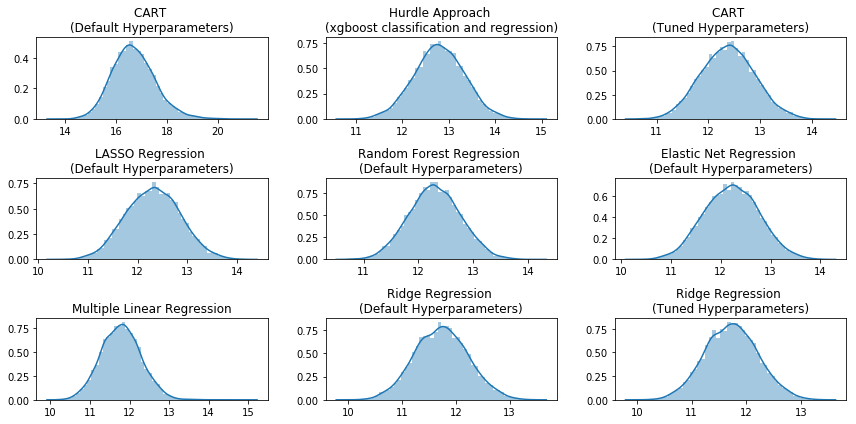

In [75]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 6))

for i, ax in enumerate(axes.flatten()):
    _ = sns.distplot(bootstrap_rmse_df_reordered.iloc[:, i], ax = ax)
    plot_title = bootstrap_rmse_df_reordered.columns[i]
    if '(' in plot_title:
        plot_title = plot_title.split('(')
        _ = ax.set_title('{}\n({}'.format(plot_title[0], plot_title[1]))
    else:
        _ = ax.set_title('{}'.format(plot_title))
    _ = ax.set_xlabel('')

fig.tight_layout()
fig.savefig('images/pop_adj_bootstrap_hist_1.png')
fig.show()

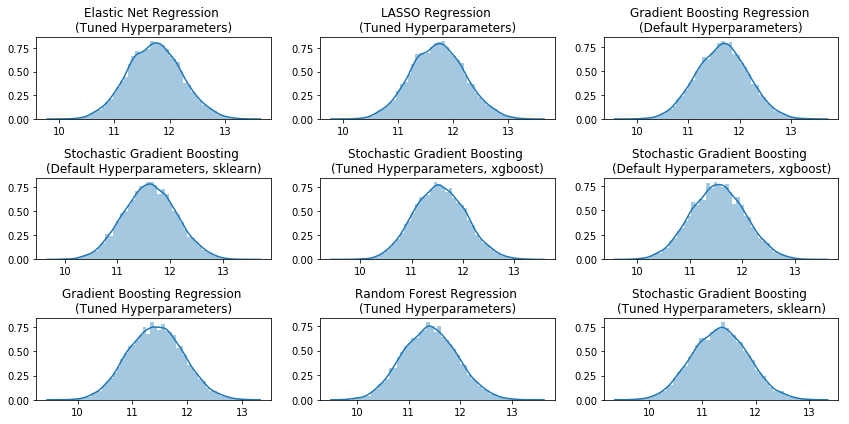

In [76]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (12, 6))

for i, ax in enumerate(axes.flatten()):
    _ = sns.distplot(bootstrap_rmse_df_reordered.iloc[:, i + 9], ax = ax)
    plot_title = bootstrap_rmse_df_reordered.columns[i + 9]
    if '(' in plot_title:
        plot_title = plot_title.split('(')
    _ = ax.set_title('{}\n({}'.format(plot_title[0], plot_title[1]))
    _ = ax.set_xlabel('')

fig.tight_layout()
fig.savefig('images/pop_adj_bootstrap_hist_2.png')
fig.show()

In [77]:
# reorder columns by median
bootstrap_rmse_df_reverse = bootstrap_rmse_df_reordered.reindex_axis(bootstrap_rmse_df_reordered.median().\
                                                                     sort_values(ascending = True).index, axis=1)

In [78]:
# create series for bootstrap distribution for the model with the lowest bootstrap median value
best_model_bootstrap_dist = bootstrap_rmse_df_reverse.iloc[:, 0]

# list to store t-test p-values
t_test_p_values = pd.DataFrame(columns = ['Model 1', 'Model 2', 'p-value'])

for i, col in enumerate(islice(bootstrap_rmse_df_reverse.columns, 1, None)):

    bootstrap_dist_model_i = bootstrap_rmse_df_reverse.iloc[:, bootstrap_rmse_df_reverse.columns.get_loc(col)]
    # equal variance f-test
    F = np.var(best_model_bootstrap_dist) / np.var(bootstrap_dist_model_i) # f-statistic
    df1 = len(best_model_bootstrap_dist) - 1 # degrees of freedom 1
    df1 = len(bootstrap_dist_model_i) - 1 # degrees of freedom 1
    p_value = scipy.stats.f.cdf(F, df1, df1) # p-value
    p_value
    if p_value > 0.05:
    # two-sample t-test
        results = (scipy.stats.ttest_ind(best_model_bootstrap_dist,\
                                         bootstrap_dist_model_i, equal_var = True))

    else:
        results = (scipy.stats.ttest_ind(best_model_bootstrap_dist,\
                                         bootstrap_dist_model_i, equal_var = False))
        
    t_test_p_values.loc[i] = [best_model_bootstrap_dist.name, bootstrap_dist_model_i.name, results[1]]

In [79]:
t_test_p_values

,Model 1,Model 2,p-value
0,Stochastic Gradient Boosting (Tuned Hyperparam...,Random Forest Regression (Tuned Hyperparameters),1.515526e-25
1,Stochastic Gradient Boosting (Tuned Hyperparam...,Gradient Boosting Regression (Tuned Hyperparam...,8.911868e-37
2,Stochastic Gradient Boosting (Tuned Hyperparam...,Stochastic Gradient Boosting (Default Hyperpar...,1.082024e-164
3,Stochastic Gradient Boosting (Tuned Hyperparam...,Stochastic Gradient Boosting (Tuned Hyperparam...,1.264246e-192
4,Stochastic Gradient Boosting (Tuned Hyperparam...,Stochastic Gradient Boosting (Default Hyperpar...,0.000000e+00
5,Stochastic Gradient Boosting (Tuned Hyperparam...,Gradient Boosting Regression (Default Hyperpar...,0.000000e+00
6,Stochastic Gradient Boosting (Tuned Hyperparam...,LASSO Regression (Tuned Hyperparameters),0.000000e+00
7,Stochastic Gradient Boosting (Tuned Hyperparam...,Elastic Net Regression (Tuned Hyperparameters),0.000000e+00
8,Stochastic Gradient Boosting (Tuned Hyperparam...,Ridge Regression (Tuned Hyperparameters),0.000000e+00
9,Stochastic Gradient Boosting (Tuned Hyperparam...,Ridge Regression (Default Hyperparameters),0.000000e+00


In [80]:
t_test_p_values.to_csv('pop_adj_t_test_p_values.csv', index = False)

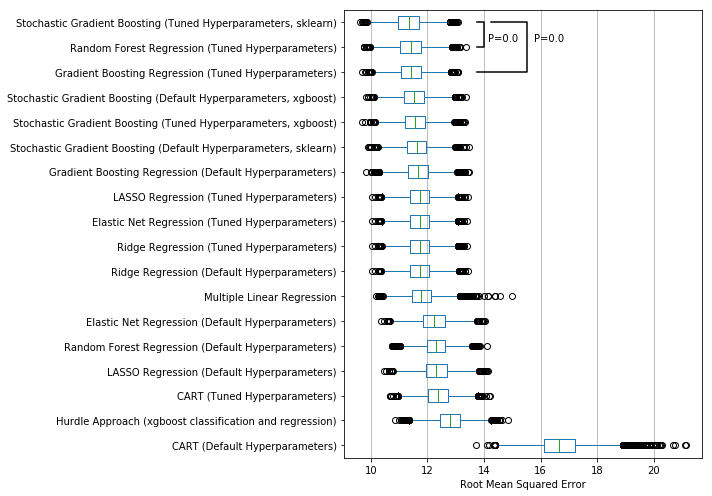

In [119]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 7))

_ = bootstrap_rmse_df_reordered.boxplot(vert = False, ax = ax)
_ = ax.yaxis.grid(False)
# _ = ax.set_title('Boxplot of Bootstrap RMSE Distributions for All Methods')
_ = ax.set_xlabel('Root Mean Squared Error')

# significance between first two models
x, h, col = bootstrap_rmse_df_reordered.iloc[0].max() + 2, 2, 'k'
ax.plot([13.75, 14, 14, 13.75], [18, 18, 17, 17], lw=1.5, c=col)
ax.text(14.15, 17.25, "P={}".format(round(t_test_p_values.iloc[0, 2], 24)), color=col)

# significance between first and third model
x, h, col = bootstrap_rmse_df_reordered.iloc[0].max() + 2, 2, 'k'
ax.plot([14.25, 15.5, 15.5, 13.75], [18, 18, 16, 16], lw=1.5, c=col)
ax.text(15.75, 17.25, "P={}".format(round(t_test_p_values.iloc[1, 2], 15)), color=col)

fig.tight_layout()
fig.savefig('images/pop_adj_boxplot_bootstrap_dist.png')
fig.show()

# Predict Opioid Overdose Mortality Rate for All Counties Using Best Model

In [82]:
# overall predictions for hurdle model
merged_remove_hurdle_no_classification_rate = merged_remove_hurdle.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)', 
                                                                                   'classification'])

merged_remove_hurdle['class_prediction'] = best_model_xgbc_hurdle.predict(merged_remove_hurdle_no_classification_rate)

merged_remove_hurdle['clf_reg_prediction'] = merged_remove_hurdle['class_prediction']

merged_remove_hurdle_no_mortality_rate = merged_remove_hurdle.drop(columns = ['Crude Opioid Mortality Rate (per 100,000)', 
                                                                              'classification',
                                                                              'class_prediction',
                                                                              'clf_reg_prediction'])

merged_remove_hurdle.loc[merged_remove_hurdle.class_prediction == 1, 'clf_reg_prediction'] = \
                            best_model_xgbr_hurdle.predict(merged_remove_hurdle_no_mortality_rate\
                                                           [merged_remove_hurdle.class_prediction == 1])

In [83]:
predictions_df = pd.DataFrame(
    {'Multiple Linear Regression' : fit_predict(X_train, y_train, X, linear_pipeline),                  
     'Ridge Regression (Default Hyperparameters)': fit_predict(X_train, y_train, X, ridge_pipeline),
   'Ridge Regression (Tuned Hyperparameters)' : fit_predict(X_train, y_train, X, best_model_ridge),
   'LASSO Regression (Default Hyperparameters)': fit_predict(X_train, y_train, X, lasso_pipeline),
   'LASSO Regression (Tuned Hyperparameters)': fit_predict(X_train, y_train, X, best_model_lasso),
   'Elastic Net Regression (Default Hyperparameters)': fit_predict(X_train, y_train, X, enet_pipeline),
   'Elastic Net Regression (Tuned Hyperparameters)': fit_predict(X_train, y_train, X, best_model_enet),
   'CART (Default Hyperparameters)': fit_predict(X_train, y_train, X, dt),
   'CART (Tuned Hyperparameters)': fit_predict(X_train, y_train, X, best_model_dt),
   'Random Forest Regression (Default Hyperparameters)': fit_predict(X_train, y_train, X, rf),
   'Random Forest Regression (Tuned Hyperparameters)': fit_predict(X_train, y_train, X, best_model_rf),
   'Gradient Boosting Regression (Default Hyperparameters)': fit_predict(X_train, y_train, X, gb),
   'Gradient Boosting Regression (Tuned Hyperparameters)': fit_predict(X_train, y_train, X, best_model_gb),
   'Stochastic Gradient Boosting (Default Hyperparameters, sklearn)': fit_predict(X_train, y_train, X, sgbr),
   'Stochastic Gradient Boosting (Tuned Hyperparameters, sklearn)': fit_predict(X_train, y_train, X, best_model_sgb),
   'Stochastic Gradient Boosting (Default Hyperparameters, xgboost)': fit_predict(X_train, y_train, X, xgbr),
   'Stochastic Gradient Boosting (Tuned Hyperparameters, xgboost)': fit_predict(X_train, y_train, X, best_model_xgbr),
   'Hurdle Approach (xgboost classification and regression)': merged_remove_hurdle.clf_reg_prediction})

In [84]:
predictions_df_reordered = predictions_df[bootstrap_rmse_df_reverse.columns]

In [85]:
predictions_df_reordered.to_csv('pop_adj_predictions_df_reordered.csv', index = False)

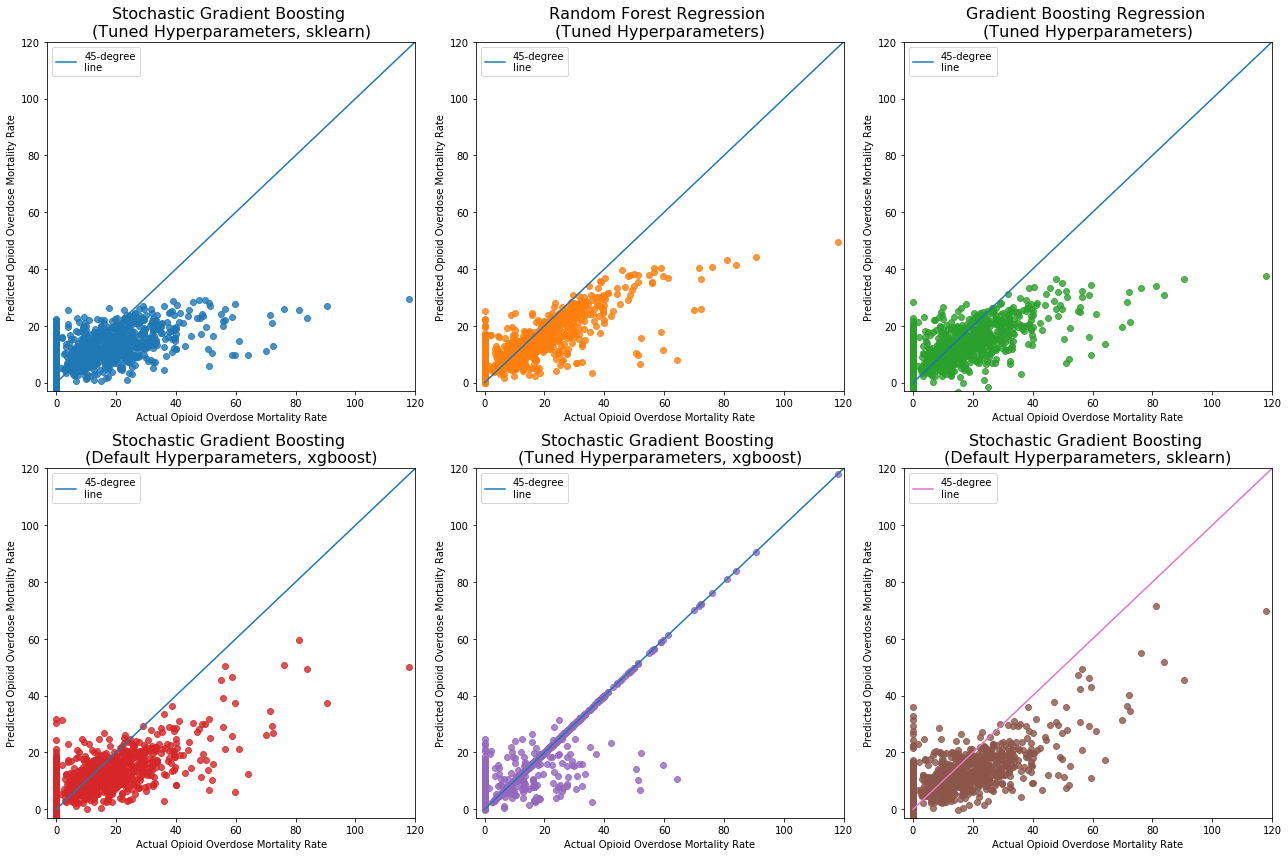

In [120]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 12))

for i, ax in enumerate(axes.flatten()):

    _ = sns.regplot(y = predictions_df_reordered.iloc[:, i], x = y, fit_reg = False, ax = ax)
    _ = ax.set_ylabel('Predicted Opioid Overdose Mortality Rate')
    _ = ax.set_xlabel('Actual Opioid Overdose Mortality Rate')
    if '(' in predictions_df_reordered.columns[i]:
        plot_title = predictions_df_reordered.columns[i].split('(')
        _ = ax.set_title('{}\n({}'.format(plot_title[0], plot_title[1]), fontsize = 16)
    else:
        plot_title = predictions_df_reordered.columns[i]
        _ = ax.set_title('{}'.format(plot_title), fontsize = 16)
    _ = ax.plot([0, 120], [0, 120]) # 45 degree line
    _ = ax.legend(['45-degree\nline'], frameon = True)
    _ = ax.set_xlim((-3, 120))
    _ = ax.set_ylim((-3, 120))

fig.tight_layout()
fig.savefig('images/pop_adj_predicted_actual_regression.png')
fig.show()

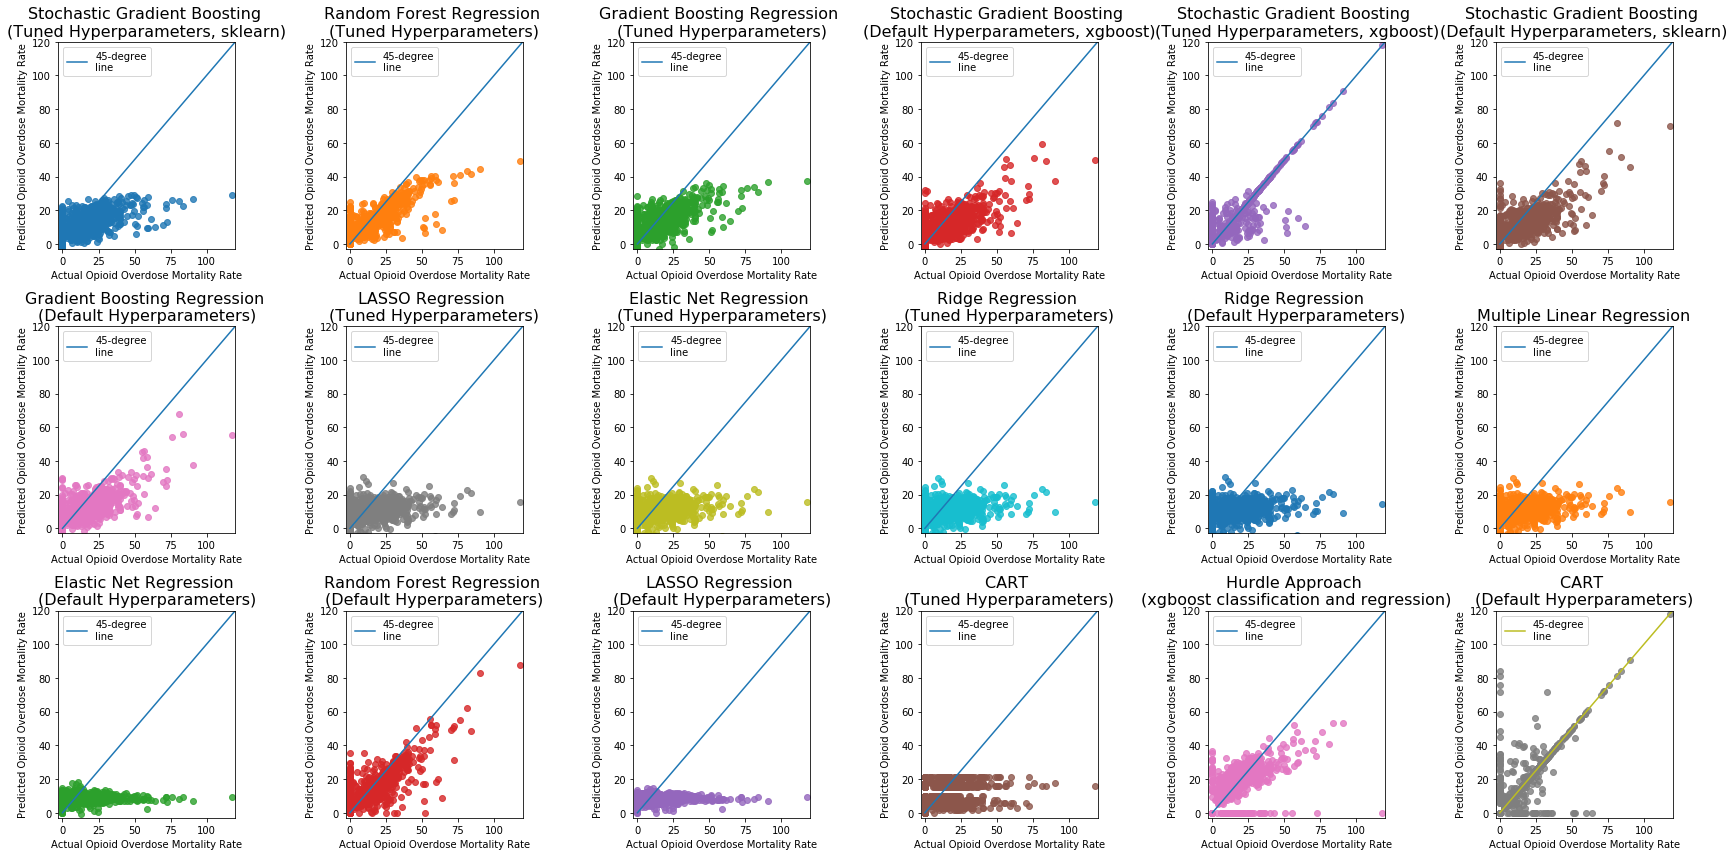

In [121]:
fig, axes = plt.subplots(nrows = 3, ncols = 6, figsize = (24, 12))

for i, ax in enumerate(axes.flatten()):

    _ = sns.regplot(y = predictions_df_reordered.iloc[:, i], x = y, fit_reg = False, ax = ax)
    _ = ax.set_ylabel('Predicted Opioid Overdose Mortality Rate')
    _ = ax.set_xlabel('Actual Opioid Overdose Mortality Rate')
    if '(' in predictions_df_reordered.columns[i]:
        plot_title = predictions_df_reordered.columns[i].split('(')
        _ = ax.set_title('{}\n({}'.format(plot_title[0], plot_title[1]), fontsize = 16)
    else:
        plot_title = predictions_df_reordered.columns[i]
        _ = ax.set_title('{}'.format(plot_title), fontsize = 16)
    _ = ax.plot([0, 120], [0, 120]) # 45 degree line
    _ = ax.legend(['45-degree\nline'], frameon = True)
    _ = ax.set_xlim((-3, 120))
    _ = ax.set_ylim((-3, 120))

fig.tight_layout()
fig.savefig('images/pop_adj_predicted_actual_regression_all.png')
fig.show()

In [88]:
y_pred_best_overall_model = predictions_df_reordered.iloc[:, 0]

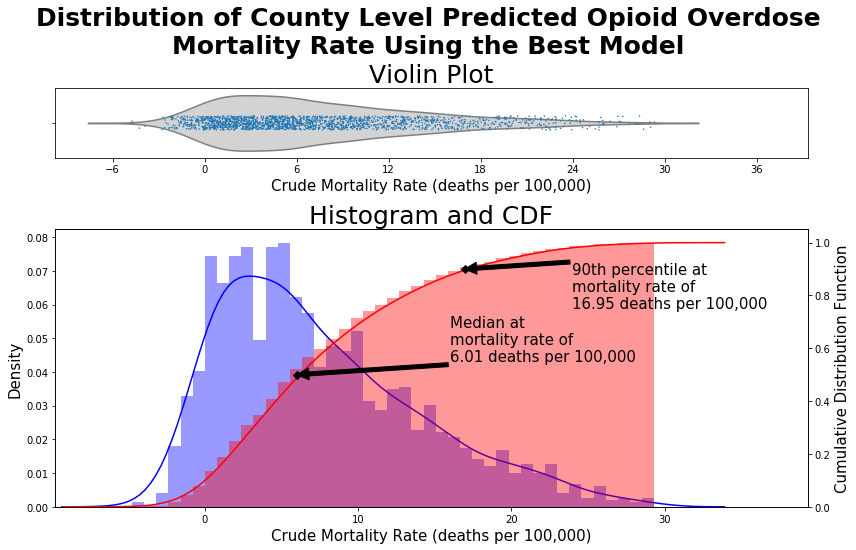

In [89]:
# Calculate number of bins to use for histogram
# Number of bins is the square root of number of data points: n_bins
n_data = len(y_pred_best_overall_model)
n_bins = np.sqrt(n_data)
# Convert number of bins to integer: n_bins
n_bins = int(n_bins)

# Cut the figure in 2 parts
f, (ax_box, ax_hist) = plt.subplots(2, gridspec_kw={"height_ratios": (.2, .8)}, figsize = (12, 8))

# Add violinplot to first subplot
sns.violinplot(y_pred_best_overall_model, inner = None, color = 'lightgray', ax = ax_box)
sns.stripplot(y_pred_best_overall_model, size = 1.5, jitter = True, ax = ax_box)

# Set x-axis name for the violinplot
ax_box.set_xlabel('Crude Mortality Rate (deaths per 100,000)', fontsize = 15)
# Set x-axis range
ax_box.set_xlim((min(y_pred_best_overall_model) - 5, max(y_pred_best_overall_model) + 10))
# Set number of tickmarks for x-axis
ax_box.xaxis.set_major_locator(plt.MaxNLocator(9))
# Set title for violinplot
ax_box.set_title("Violin Plot", fontsize = 25)

# Add histogram to second subplot
sns.distplot(y_pred_best_overall_model, color = 'blue', bins = n_bins, ax=ax_hist)

# Have an overlaying plot for second subplot
ax_hist2 =ax_hist.twinx()

# Overlay ecdf to histogram
sns.distplot(y_pred_best_overall_model, 
             color = 'red', 
             bins= n_bins, 
             kde_kws = dict(cumulative = True), 
             hist_kws=dict(cumulative=True), 
             ax=ax_hist2)

# Calculate median for cdf
median = np.percentile(y_pred_best_overall_model, 50)
# Plot point at median
_ = plt.plot(median, .5, marker='D', color='black',
         linestyle='none')
# Add arrow at median with text
ax_hist2.annotate('Median at\nmortality rate of\n{} deaths per 100,000'.format(round(median, 2)), 
                  xy=(median, .5), 
                  xytext=(median + 10, 0.55),
                  arrowprops=dict(facecolor='black'),
                  fontsize = 15)

# Calculate 90th percentile for cdf
percentile_90th = np.percentile(y_pred_best_overall_model, 90)
# Plot point at 90th percentile
_ = plt.plot(percentile_90th, .9, marker='D', color='black',
         linestyle='none')
# Add arrow at 90th percentile with text
ax_hist2.annotate('90th percentile at\nmortality rate of\n{} deaths per 100,000'.format(round(percentile_90th, 2)), 
                  xy=(percentile_90th, .9), 
                  xytext=(percentile_90th + 7, 0.75),
                  arrowprops=dict(facecolor='black'),
                  fontsize = 15)

# Set x-axis limit for histogram
ax_hist.set_xlim((min(y_pred_best_overall_model) - 5, max(y_pred_best_overall_model) + 10))

# Add axis labels for histogram and cdf
ax_hist.set_title("Histogram and CDF", fontsize = 25)
ax_hist.set_ylabel('Density', fontsize = 15)
ax_hist.set_xlabel('Crude Mortality Rate (deaths per 100,000)', fontsize = 15)
ax_hist2.set_ylabel('Cumulative Distribution Function', fontsize = 15)

# Add title to figure
f.suptitle('Distribution of County Level Predicted Opioid Overdose\nMortality Rate Using the Best Model', 
           fontsize = 25, fontweight = 'bold')

# Adjust plot layout
f.tight_layout(rect = [0, 0.03, 1, 0.9])
f.show()

In [90]:
merged_data = pd.read_csv('merged_data.csv')

In [91]:
merged_data.shape

(2962, 39)

In [92]:
merged_data['Predicted Mortality Rate'] = y_pred_best_overall_model

In [93]:
merged_data['Predicted Mortality Rate'].describe()

count    1884.000000
mean        7.519856
std         6.511156
min        -4.739256
25%         2.411522
50%         6.014283
75%        11.493179
max        29.328420
Name: Predicted Mortality Rate, dtype: float64

In [94]:
merged_data.head()

,fips_code,population,crude_opioid_mortality_rate,state,opioid_prescription_rate,%_povall_2016,pop_chg_2016,gq_estimates_2016,rate_birth_2016,rate_international_mig_2016,...,5_9_years_%,60_64_years__%,65_69_years_%,70_74_years_%,75_79_years_%,80_84_years_%,85+_years_%,less_than_1_year_%,county,Predicted Mortality Rate
0,1001,55416.0,0.0,AL,129.6,14.0,440.0,455.0,12.096335,0.272440,...,6.620832,5.557962,4.805471,3.847264,2.869207,1.894760,1.311895,1.131442,Autauga,8.831514
1,1003,208563.0,8.6,AL,123.8,12.0,4646.0,2275.0,11.267825,0.823643,...,5.957912,6.897676,6.769178,5.161510,3.553363,2.250639,1.973504,1.097510,Baldwin,7.340403
2,1005,25965.0,0.0,AL,92.7,30.0,-490.0,2977.0,10.453899,-0.192167,...,6.204506,6.339303,6.192952,4.698633,3.158097,2.183709,1.783170,0.955132,Barbour,0.843629
3,1007,22643.0,0.0,AL,97.2,20.0,72.0,2201.0,12.833562,0.885073,...,5.546968,5.895862,5.383562,3.833414,2.976637,1.815131,1.422073,1.157090,Bibb,2.942195
4,1009,57704.0,0.0,AL,56.9,14.0,-28.0,489.0,11.723635,1.076838,...,6.476154,6.372175,6.094898,4.737973,3.292666,2.181824,1.679260,1.147234,Blount,1.988424


In [95]:
merged_data.loc[:, ].sort_values(by = 'crude_opioid_mortality_rate', ascending=False).head()

,fips_code,population,crude_opioid_mortality_rate,state,opioid_prescription_rate,%_povall_2016,pop_chg_2016,gq_estimates_2016,rate_birth_2016,rate_international_mig_2016,...,5_9_years_%,60_64_years__%,65_69_years_%,70_74_years_%,75_79_years_%,80_84_years_%,85+_years_%,less_than_1_year_%,county,Predicted Mortality Rate
989,21097,18646.0,118.0,KY,96.3,15.0,-48.0,275.0,12.142704,1.128304,...,5.985198,6.843291,5.926204,3.984769,3.207122,2.091601,1.791269,1.190604,Harrison,29.328420
2819,54011,95987.0,90.6,WV,122.3,22.0,-793.0,4077.0,11.065367,0.718260,...,5.530957,6.246679,5.939346,4.110973,3.100420,2.286768,2.275308,1.177243,Cabell,26.875799
2863,54099,40531.0,83.9,WV,67.5,22.0,-507.0,246.0,9.942956,0.000000,...,5.719079,6.965039,6.807135,4.746984,3.508426,2.304409,2.193383,0.994301,Wayne,22.674333
2843,54059,24647.0,81.1,WV,96.5,28.0,-601.0,85.0,11.810630,0.000000,...,6.061590,7.883312,6.816245,3.874711,2.844160,1.858238,1.432223,1.294275,Mingo,25.719345
1162,24510,614664.0,76.1,MD,54.6,22.0,-6073.0,26089.0,13.672702,3.695194,...,5.986035,5.764125,4.671821,2.934449,2.104727,1.504074,1.652285,1.384822,Baltimore City,26.030430


In [96]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'crude_opioid_mortality_rate', ascending=False).head(20)

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
989,Harrison,KY,118.0,29.328420
2819,Cabell,WV,90.6,26.875799
2863,Wayne,WV,83.9,22.674333
2843,Mingo,WV,81.1,25.719345
1162,Baltimore City,MD,76.1,26.030430
1716,Rio Arriba,NM,72.4,12.797436
2815,Berkeley,WV,72.2,21.181380
724,Scott,IN,71.6,23.839973
1137,Washington,ME,70.0,11.004777
981,Grant,KY,64.2,9.865571


In [97]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'Predicted Mortality Rate').head()

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
883,Jefferson,KS,0.0,-4.739256
1335,Todd,MN,0.0,-4.256043
817,Plymouth,IA,0.0,-3.888016
1590,Cass,NE,0.0,-2.765100
1079,Franklin,LA,0.0,-2.712087


In [98]:
merged_data.loc[:, ['county', 'state', 'crude_opioid_mortality_rate', 'Predicted Mortality Rate']].\
                            sort_values(by = 'crude_opioid_mortality_rate').head()

,county,state,crude_opioid_mortality_rate,Predicted Mortality Rate
0,Autauga,AL,0.0,8.831514
1796,Bertie,NC,0.0,2.688592
1797,Bladen,NC,0.0,5.073288
1804,Caswell,NC,0.0,3.234157
1806,Chatham,NC,0.0,6.210268


In [99]:
# overall mse using best model
np.sqrt(np.mean((y - y_pred_best_overall_model)**2))

9.555946248778723

# Feature Importance Based on Best Models

In [100]:
# create a list of models (excluding hurdle approach)
models_lst = [linear_pipeline, 
              ridge_pipeline, 
              best_model_ridge, 
              lasso_pipeline, 
              best_model_lasso, 
              enet_pipeline, 
              best_model_enet, 
              dt,
              best_model_dt,
              rf,
              best_model_rf,
              gb,
              best_model_gb,
              sgbr,
              best_model_sgb,
              xgbr,
              best_model_xgbr]

In [101]:
# create labels for models (excluding hurdle approach)
model_labels = bootstrap_rmse_df.columns[:-1]

#  
model_dict = dict(zip(model_labels, models_lst))

In [102]:
model_dict_ordered = collections.OrderedDict()

In [103]:
for column in [column for column in bootstrap_rmse_df_reverse.columns if 'Hurdle' not in column]:
    model_dict_ordered['{}'.format(column)] = model_dict[column]

In [104]:
model_dict_ordered_keys_list = list(model_dict_ordered.keys())
model_dict_ordered_items_list = list(model_dict_ordered.items())

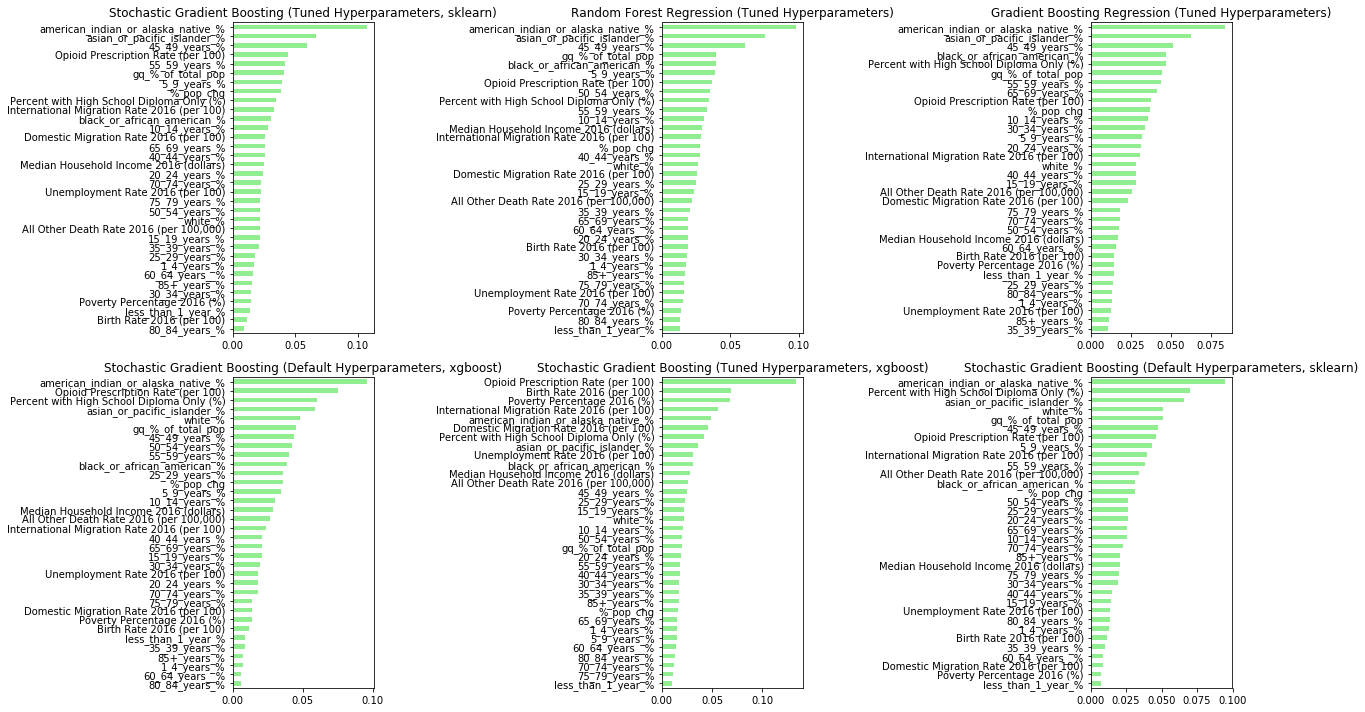

In [105]:
f, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (18, 10))

for i, ax in enumerate(axes.flatten()):
    if 'Default' in model_dict_ordered_keys_list[i]:
        # create a pd.Series of features importances
        feature_importances = pd.Series(model_dict_ordered_items_list[i][1].feature_importances_, index = X.columns)
    else:
        feature_importances = pd.Series(model_dict_ordered_items_list[i][1].steps[0][1].feature_importances_, index = X.columns)
        
    # sort feature_importances
    sorted_importances = feature_importances.sort_values()

    # make a horizontal bar plot
    sorted_importances.plot(kind = 'barh', color = 'lightgreen', ax=ax)
    ax.set_title('{}'.format(model_dict_ordered_keys_list[i]))
f.tight_layout()
# f.savefig('images/pop_adj_feature_importances.png')
f.show()